# Cannula CrackDetection

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2784715868302467776
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3281362944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2013450115546075357
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [2]:
%matplotlib inline

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle

from tensorflow import keras
#import keras

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

Total data count: 943


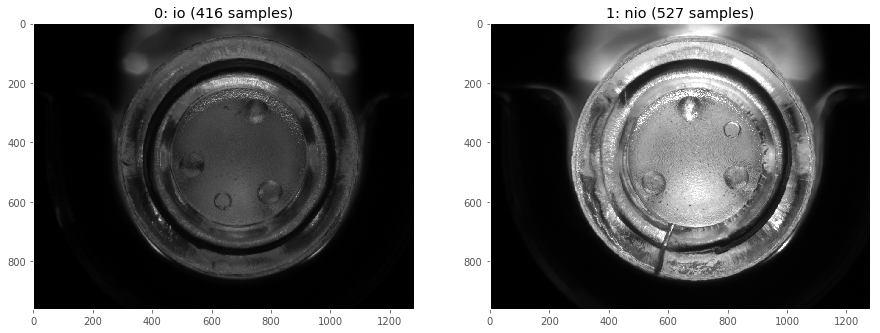

In [3]:
from tensorflow.keras.utils import to_categorical

plt.style.use('ggplot')

directories = {'io': r'.\2017-09-14_Neue_Messungen\Ohne_Riss', 'nio': r'.\2017-09-14_Neue_Messungen\Mit_Riss'}
#directories = {'io': r'.\img\pyramid_good', 'nio': r'.\img\pyramid_bad'}

labels = {'io': 0, 'nio': 1}

# load all image paths
sample_img = {}
X_train, y_train = [], []
for key, path in directories.items():
    X = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.tif')]#[0:98]
    y = [labels[key]] * len(X)
    label = "{}: {} ({} samples)".format(labels[key], key, len(X))
    sample_img[label] = os.path.join(path, os.listdir(path)[random.randint(0, len(X) - 1)])
    X_train += X
    y_train += y

X_train = np.array(X_train)    
y_train = to_categorical(np.array(y_train), num_classes=len(directories.items()))
#y_train = np.array(y_train)

X_train, y_train = shuffle(X_train, y_train)

assert(len(X_train) == len(y_train))
print("Total data count:", len(X_train))

figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
for ax, (label, path) in zip(axes.ravel(), sample_img.items()):
    ax.grid(b=False)
    ax.imshow(mpimg.imread(path), cmap='gray')
    ax.set_title(label)

## Preprocessing

In [4]:
import cv2

def load_preprocess(x):
    
    ret = []
    for path in x:
        img = mpimg.imread(path)
        
        # CROP
        h = img.shape[0]
        w = img.shape[1]
        
        crop = [0, 0, int((w-h)/2), int((w-h)/2)] # px above, beneath, left, right
        img = img[crop[0]:h-crop[1], crop[2]:w-crop[3]]
        
        # RESIZE
        size = (224,224)
        img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
        
        ret.append(img)
    
    return np.array(ret)[:,:,:,np.newaxis]
    #return np.array(ret)

#print(X_train.shape)
#print(load_preprocess(X_train).shape)
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
for ax, (label, path) in zip(axes.ravel(), sample_img.items()):
    ax.grid(b=False)
    img = np.squeeze(load_preprocess([path])[0])
    ax.imshow(img, cmap='gray')
    ax.set_title('{} Size: {}'.format(label, img.shape))

ImportError: DLL load failed: Das angegebene Modul wurde nicht gefunden.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=42)

print("Samples in training set:", len(X_train))
print("Samples in validation set:", len(X_valid))
print("Samples in test set:", len(X_test))

Samples in training set: 754
Samples in validation set: 141
Samples in test set: 48


## CNN Architecture

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

model = Sequential()
model.add(Lambda(lambda x: (x-32768)/32768, input_shape=(224, 224, 1)))
model.add(Conv2D(16, (5, 5), padding='same'))#, input_shape=(224, 224, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))

adam=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
keras.__version__

'2.1.6-tf'

In [8]:
from sklearn.preprocessing import LabelBinarizer

def data_generator(X_train, y_train, batch_size=256):
    label_binarizer = LabelBinarizer()
    
    while True:
        for batch in range(0, len(X_train), batch_size):
            X_batch, y_batch = [], []
            
            X_batch = load_preprocess(X_train[batch:batch+batch_size])
            y_batch = np.array(y_train[batch:batch+batch_size])
                
            yield X_batch, y_batch

In [9]:
train_generator = data_generator(X_train, y_train, batch_size=32)
valid_generator = data_generator(X_valid, y_valid, batch_size=32)

early_stopping = EarlyStopping(monitor='val_acc', patience=1, verbose=1)

#model.fit(load_preprocess(X_train), y_train, epochs=8, validation_data=(load_preprocess(X_valid), y_valid))
model.fit_generator(train_generator, len(X_train), epochs=5, callbacks=[early_stopping], validation_data=valid_generator, validation_steps=len(X_valid))
#model.fit_generator(train_generator, len(X_train), epochs=4, validation_data=valid_generator, validation_steps=len(X_valid))

Epoch 1/5
  1/754 [..............................] - ETA: 2:00:47 - loss: 0.7996 - acc: 0.4688

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
from keras import backend as K

K.tensorflow_backend.get_session()

In [ ]:
import tensorflow as tf

tf.device('/gpu:0')

In [ ]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1352769706672855748
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 172875776
locality {
  bus_id: 1
}
incarnation: 12698189300842167171
physical_device_desc: "device: 0, name: GeForce GTX 750, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [ ]:
# Save model for later use
model.save("model_2017_06_23_1.h5")

In [ ]:
from keras.models import load_model

model = load_model("model_2017_06_23_1.h5")
test_images = []
#for path in X_test:
#    img = mpimg.imread(path)
#    test_images.append(img)
    
test_images = np.array(load_preprocess(X_test))
score = model.evaluate(test_images, y_test)
print("Test Accuracy:", score[1])

## Predicting Test Data
Zu testende Daten werden automatisch aus dem Ordner __test-images__ geladen

In [ ]:

#test_path = "test_images"
#X = [mpimg.imread(os.path.join(test_path, f)) for f in os.listdir(test_path)]
#X_red = np.int32([resize_image(img) for img in X])
#pred = model.predict(X_red)

#figs, axes = plt.subplots(nrows=len(X), ncols=2, figsize=(15, len(X)*5))
#for ax, img, result in zip(axes, X, pred):
#    names = ['beet', 'arabidopsis', 'corn', 'tomato', 'wheat', 'tobacco']
#    y_pos = np.arange(len(names))
#    ax[0].grid(b=False)
#    ax[0].imshow(img)
#    ax[1].barh(y_pos, result)
#    ax[1].set_xlim([0.0,1.05])
#    ax[1].set_yticks(y_pos)
#    ax[1].set_yticklabels(names)
    
#    for i, v in enumerate(result):
#        ax[1].text(v + 0.02, i, str(round(v,2)))

In [ ]:
test_images = load_preprocess(X_test)
#img = np.squeeze(load_preprocess([path])[0])

figs, axes = plt.subplots(nrows=15, ncols=2, figsize=(15,150))
for ax, (x, y) in zip(axes.ravel(), zip(test_images, y_test)):
    ax.grid(b=False)
    #img = np.squeeze(load_preprocess([path])[0])
    #print(x.shape)
    ax.imshow(np.squeeze(x), cmap='gray')
    ax.set_title('L: {},\n P: {}'.format(y, model.predict(x[np.newaxis,:,:,:])))